In [56]:
import numpy as np
import scipy 
import random
import math
import csv
from scipy.stats import poisson 
from scipy.integrate import quad
import sklearn.metrics.pairwise as sk
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.spatial import distance
from matplotlib import pyplot as plt
import sklearn.gaussian_process.kernels as kern
import pandas as pd
import scipy.io
from tabulate import _table_formats, tabulate
import seaborn as sns  # for nicer graphics
import warnings
import nbimporter
import Performance_metrics as metrics
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import FormatStrFormatter

In [57]:
folder = '../Data/neurons_dataset/'
num_realisation = 1

## Create dataset from the original mat file 

In [58]:
data = scipy.io.loadmat(folder + '11207-27060501_t1c3.mat')

In [59]:
x_1 = data['x1']
y_1 = data['y1']

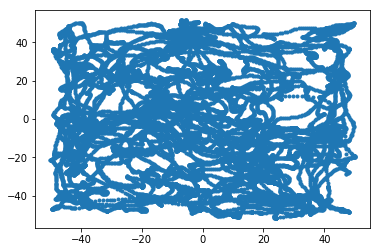

In [60]:
positions = np.concatenate((x_1, y_1), axis = 1) 
plt.scatter(positions[:, 0], positions[:, 1],marker = '.')

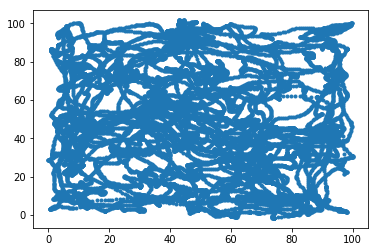

In [61]:
positions = np.concatenate((x_1, y_1), axis = 1) + 50
plt.scatter(positions[:, 0], positions[:, 1],marker = '.')
filter1 = (positions[:,1]>=0)
filter2 = (positions[:,1]<=100)
filtered_positions = positions[filter1&filter2]

In [62]:
##### Shuffle the filtered_positions to select xtrain and xtest at random
filtered_positions = positions[filter1&filter2]
print(filtered_positions.shape)
np.random.seed(15)
np.random.shuffle(filtered_positions)
xtrain = filtered_positions[:583,:]
xtest = filtered_positions[583:,:]
xtest_dataset = xtest

(29710, 2)


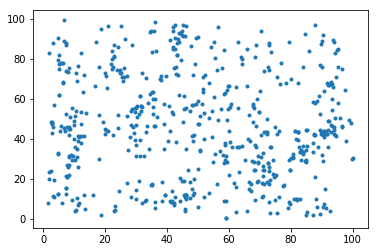

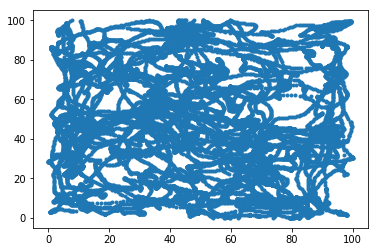

In [63]:
## Train data
plt.scatter(xtrain[:,0], xtrain[:,1],marker = '.')
plt.show()
## Test data
plt.scatter(xtest[:,0], xtest[:,1],marker = '.')
plt.show()

In [64]:
## Tau ragion
min_x = np.min(xtrain[:,0])
max_x = np.max(xtrain[:,0])
min_y = np.min(xtrain[:,1])
max_y = np.max(xtrain[:,1])
print('min_x', min_x)
print('max_x', max_x)
print('min_y', min_y)
print('max_y', max_y)

min_x 1.6708510985757101
max_x 100.0
min_y 0.5884886314265927
max_y 99.21697051843452


In [65]:
x_data = np.linspace(0, 100, num=50)
y_data = np.linspace(0, 100, num=50)
mesh_inputs = np.asarray(np.meshgrid(x_data,y_data))
X_mesh, Y_mesh = np.meshgrid(x_data,y_data)
X_grid = np.vstack([X_mesh.flatten(),Y_mesh.flatten()]).T
xtest = X_grid

In [66]:
area = 100.*100.

In [67]:
original_scale = xtrain.shape[0]/area
new_scale = xtest.shape[0]/area

## Import results

In [68]:
## To compute perfomances
pred_mean_MTSM = np.load('../Data/neurons_dataset/pred_mean_MTSM_4.npy')
pred_var_MTSM = np.load('../Data/neurons_dataset/pred_var_MTSM_4.npy')
latent_means = np.load('../Data/neurons_dataset/latent_means_MTSM_4.npy')
latent_vars = np.load('../Data/neurons_dataset/latent_variances_MTSM_4.npy')
alpha_final = np.load('../Data/neurons_dataset/alpha_final_MTSM_4.npy')
beta_final = np.load('../Data/neurons_dataset/beta_final_MTSM_4.npy')
samples_latent_function = np.load('../Data/neurons_dataset/samples_latent_function_MTSM_4.npy')

time_interations = np.load('../Data/neurons_dataset/time_iterations_MTSM_4.npy')
time_to_train_list = np.load('../Data/neurons_dataset/time_to_train_list_MTSM_4.npy')

## To assess convergence
nelbo = np.load('../Data/neurons_dataset/nelbo_values_MTSM_4.npy')
cross_entropy_U = np.load('../Data/neurons_dataset/crossent_vector_MTSM_4.npy')
entropy_U = np.load('../Data/neurons_dataset/ent_vector_MTSM_4.npy')
entropy_locations = np.load('../Data/neurons_dataset/ent_x_m_vector_MTSM_4.npy')
ell = np.load('../Data/neurons_dataset/ell_vector_MTSM_4.npy')
value_for_events_locations_vector = np.load('../Data/neurons_dataset/value_for_events_locations_vector_MTSM_4.npy')
value_for_thinned_events_vector = np.load('../Data/neurons_dataset/value_for_thinned_events_vector_MTSM_4.npy')

probabilities_mixture_vector = np.load('../Data/neurons_dataset/probabilities_mixture_vector_MTSM_4.npy')
means_mixture_vector = np.load('../Data/neurons_dataset/means_mixture_vector_MTSM_4.npy')
variances_mixture_vector = np.load('../Data/neurons_dataset/variances_mixture_vector_MTSM_4.npy')
value_expectation_vector = np.load('../Data/neurons_dataset/value_expectation_vector_MTSM_4.npy')
kl_lambda_max_vector = np.load('../Data/neurons_dataset/kl_lambda_max_vector_MTSM_4.npy')



## Performance

In [69]:
num_grid_points = 50
X_grid = np.empty([num_grid_points, 2])
X_grid[:, 0] = np.linspace(0, 100, num_grid_points)
X_grid[:, 1] = np.linspace(0, 100, num_grid_points)
X_mesh, Y_mesh = np.meshgrid(X_grid[:, 0],X_grid[:, 1])
X_vec = X_grid
x_test = np.vstack([X_mesh.flatten(),Y_mesh.flatten()]).T
area_cell = 2.04081633**2
num_samples = 100

In [70]:
## Probality of observing n_train + n_test
nlpl_mean, nlpl_std = metrics.compute_nlpl(x_test, 1, latent_means, latent_vars, 
             filtered_positions, 'sigmoidal', num_samples, alpha_final, beta_final, 
                            area_cell = area_cell, code = 'Py', dim = 2)
print('nlpl', nlpl_mean)

nlpl 95.05170000418728


In [71]:
## Probality of observing n_train + n_test
nlpl_in_sample_mean, nlpl_in_sample_std =  metrics.compute_nlpl(x_test, 1, latent_means, latent_vars, 
             xtrain, 'sigmoidal', num_samples, alpha_final, beta_final, area_cell = area_cell, code = 'Py', dim = 2)
print('nlpl_in_sample', nlpl_in_sample_mean)


nlpl_in_sample 171.73147795865538


In [72]:
l_test_mean, l_test_std = metrics.compute_l_test(num_realisation, x_test, xtest_dataset, 
               'sigmoidal', num_samples, area_cell = area_cell, latent_means = latent_means, latent_vars = latent_vars, 
               alpha = alpha_final, beta = beta_final,
                   dim = 2, code ='Py')
print('l_test_mean', l_test_mean)

l_test_mean -49787.49444474316


## Plots

###  Counts distributions

In [73]:
levels = np.array([10,20,30,40,50])

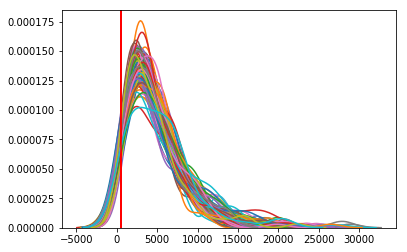

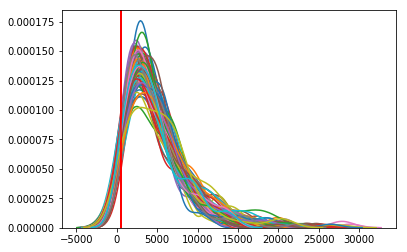

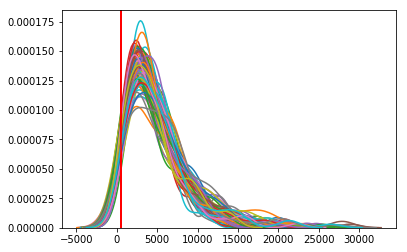

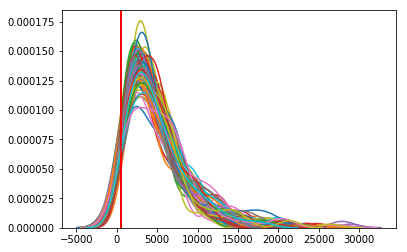

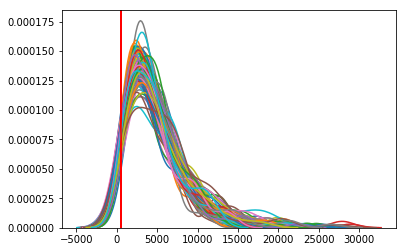

0.0
0.0


In [74]:
num_samples = 100
n_seeds = 100
count_matrix_our_train = np.zeros((num_samples, n_seeds))
true_number_events = xtrain.shape[0]
coverage = np.zeros((levels.shape[0],n_seeds))
for j in range(levels.shape[0]):
    for s in range(n_seeds):
        np.random.seed(s + j)
        for i in range(num_samples):
            lambda_max = np.random.gamma(alpha_final, 1/(beta_final))
            latent_function = latent_means + np.sqrt(latent_vars)*np.random.normal(0, 1)
            intensity = (lambda_max*metrics.sigmoidal(latent_function))[0]
            volume = np.sum((2.04081633**2)*intensity)
            count_matrix_our_train[i,s] = np.random.poisson(volume)

        lower_5percentile = np.percentile(count_matrix_our_train[:,s], levels[j])
        upper_95percentile = np.percentile(count_matrix_our_train[:,s], 100 - levels[j])

        if true_number_events >= lower_5percentile and true_number_events <= upper_95percentile:
            coverage[j, s] = 1.
        else:
            coverage[j, s] = 0.
        sns.kdeplot(count_matrix_our_train[:,s])
        plt.axvline(xtrain.shape[0], color ='red')
    plt.show()

print(np.mean(coverage))
print(np.std(coverage))

mean_coverage = np.mean(coverage, axis = 1)
std_coverage = np.std(coverage, axis = 1)


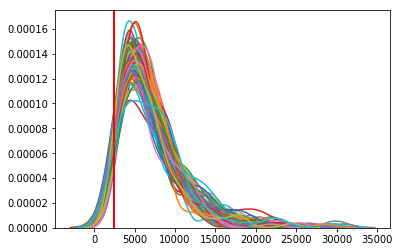

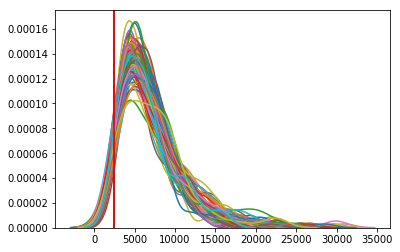

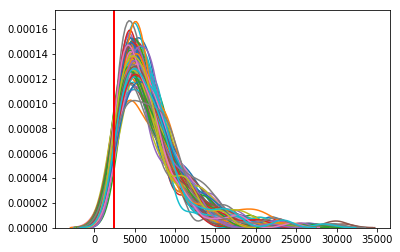

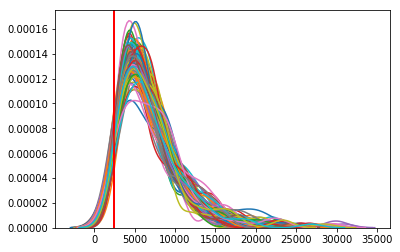

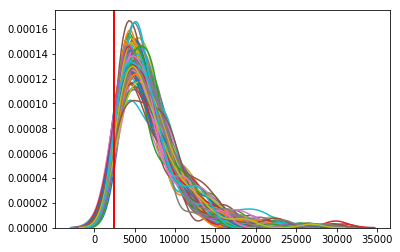

0.0
0.0


In [55]:
num_samples = 100
n_seeds = 100
count_matrix_our_test = np.zeros((num_samples, n_seeds))
true_number_events = xtest.shape[0]
coverage_test = np.zeros((levels.shape[0],n_seeds))
for j in range(levels.shape[0]):
    for s in range(n_seeds):
        #print('seed', s)
        np.random.seed(s + j)
        for i in range(num_samples):
            #print('i', i)
            lambda_max = np.random.gamma(alpha_final, 1/(beta_final))
            latent_function = latent_means + np.sqrt(latent_vars)*np.random.normal(0, 1)
            intensity = (lambda_max*metrics.sigmoidal(latent_function) + new_scale - original_scale)[0]
            volume = np.sum((2.04081633**2)*intensity)
            count_matrix_our_test[i,s] = np.random.poisson(volume)

        lower_5percentile = np.percentile(count_matrix_our_test[:,s], levels[j])
        upper_95percentile = np.percentile(count_matrix_our_test[:,s], 100 - levels[j])

        if true_number_events >= lower_5percentile and true_number_events <= upper_95percentile:
            coverage_test[j, s] = 1.
        else:
            coverage_test[j, s] = 0.
        sns.kdeplot(count_matrix_our_test[:,s])
        plt.axvline(xtest.shape[0], color ='red')
    plt.show()

print(np.mean(coverage_test))
print(np.std(coverage_test))

mean_coverage_test = np.mean(coverage_test, axis = 1)
std_coverage_test = np.std(coverage_test, axis = 1)

### Intensities

In [76]:
cmap = 'Reds'

font = {'color':  'black',
        'weight': 'normal',
        'size': 19,
        }
size_points = 10
color_points = 'black'

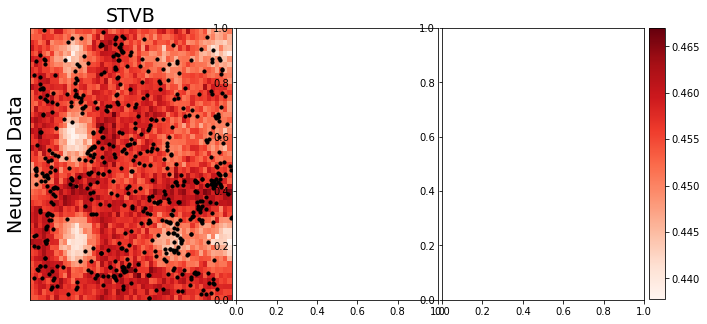

In [77]:
num_methods = 3
f, ((ax1, ax2, ax3)) = plt.subplots(1, num_methods)
f.set_figheight(5)
f.set_figwidth(11)
f.subplots_adjust(hspace=0.02)
f.subplots_adjust(wspace=0.02)

im = ax1.pcolor(X_vec[:,0], X_vec[:,1], pred_mean_MTSM[0].reshape([num_grid_points, num_grid_points]),cmap=cmap)
ax1.scatter(xtrain[:,0],xtrain[:,1],s=size_points, c=color_points)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([X_vec[0,0],X_vec[-1,0]])
ax1.set_ylim([X_vec[0,1],X_vec[-1,1]])
ax1.set_title('STVB',fontdict=font)
ax1.set_ylabel('Neuronal Data', fontdict=font)

cbar_ax = f.add_axes([0.906, 0.127, 0.02, 0.752])
f.colorbar(im, cax=cbar_ax)
plt.show()